# Image Stitching:  The final step
Reading: Szeliski 6.1, 9.1

## Homographies

We have successfully made our way through all the steps of image stitching save one.  We have detected keypoints from two images (called image 1 and image 2), generated descriptors, matched them together, and now all we need to do is to determine the way in which we need to move one image (let's call it image 2) such that its pixel intensity information is in *the same coordinate system as image 1*.  

As it turns out, under a very specific assumption about the motion of the camera between images, this transformation is a linear operation called a *homography*.  To see exactly what this operation does, let's reference the following image:

<img src="homography.jpg">

In this image, the blue points are *things* out in the real world, perhaps ones that we've identified as corners and come up with descriptors for.  We'll assume that we've already solved the problem of correspondence: if we see a corner in both images, we have successfully matched it.  These corners reflect light and send out a ray (blue line) which impacts the effective focal plane of the camera.  In the figure, these impacts are denoted by an X in a color corresponding to the image whose focal plane was impacted.  What we need to do is to determine where corners that impacted the second image would have impacted the focal plane of the first image *if that first image had its sensor synthetically extended*, i.e. what are the coordinates of that black question mark?  We can determine this mapping by looking at the points for which we have correspondences.

As it turns out, the transformation from one 2D plane embedded in 3D to another obeys a linear transformation called a *homography*.  A homography is a linear transformation that preserves straight lines (and nothing else).  It occupies the most expressive position on a continuum that ranges from simple rotation (governed by one parameter), to rotation-translations (which preserve scale and relative orientation and position of points), to affine transformations (which preserve scale and parallelity), to homographies (which only preserve straight lines).  We can define it as
$$
\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = \begin{bmatrix} h_{11} & h_{12} & h_{13}\\
                                                               h_{21} & h_{22} & h_{23}\\
                                                               h_{31} & h_{32} & h_{33} \end{bmatrix} 
                                                               \begin{bmatrix} u \\
                                                                               v \\
                                                                               1 \end{bmatrix}
$$                                                               
Note that this makes use of generalized coordinates: after the transformation, we need to divide: $u' = x'/w'$ and $v' = y'/w'$.  What does a homography do?  Here is an example of a random homography on the unit square:


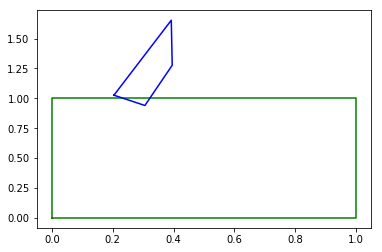

In [9]:
import numpy as np
import matplotlib.pyplot as plt


X = np.array([[0,0,1],
              [1,0,1],
              [1,1,1],
              [0,1,1],
              [0,0,1]])

H = np.random.rand(3,3)
#H/= H[2,2]

Xprime = (H @ X.T).T
Xprime/=Xprime[:,2][:,np.newaxis]

plt.plot(X[:,0],X[:,1],'g-')
plt.plot(Xprime[:,0],Xprime[:,1],'b-')
plt.show()

How do we solve for this thing given our point correspondences?  We need an equation for the eight unknowns in the matrix $H$.  By doing some algebra, we find that we can generate a linear system of equations for the coefficients of $H$:
$$
A \vec{h} = 0,
$$
where
$$
\vec{h} = \begin{bmatrix} h_{11}, h_{12}, \ldots, h_{32}, h_{33} \end{bmatrix}
$$
and 
$$
A = \begin{bmatrix}  0 & 0 & 0 & -u_1 & -v_1 & -1 & v_1' u_1 & v'_1 v_1& v'_1 \\
                     u_1 & v_1 & 1 &  0   & 0    &  0 & -u'_1 u_1 & -u'_1 v_1 & -u'_1 \\
                     \vdots & \ddots & & & & & & & \vdots \\
                     0 & 0 & 0 & -u_n & -v_n & -1 & v_n' u_n & v'_n v_n& v'_n \\
                     u_n & v_n & 1 &  0   & 0    &  0 & -u'_n u_n & -u'_n v_n & -u'_n \end{bmatrix}
$$                     

Note that for this matrix problem to be well-posed, $n$ (the number of correspondences) must equal 4.  Even still, this system is singular: this is because $h$ is only really defined up to a constant.  Thus, the entries of $h$ are in the nullspace of $A$.  Fortunately, finding this nullspace is easy: take the singular value decomposition of $A$, i.e.
$$
SVD(A) = U \Sigma V^T.
$$
If the singular values (the entries in $\Sigma$) are in descending order (as they usually are), then the nullspace of $A$ is given by the corresponding vector in $V$, or the bottom row in $V^T$.  

As it turns out this SVD-based method for finding the nullspace is also applicable when $n>4$, e.g. we have more correspondences than the requisite 4.  In the case of this overdetermined system, there won'd be a nullspace, but the optimal solution for the homography matrix is still given by the column in $V$ that corresponds to the smallest singular valuem, and there is no change to the routine (except that $A$ has more rows). 

**Your assignment is to generate code that takes a set of point correspondences $\{(u_i,v_i, u'_i,v'_i)\}$ for $i$ in $n$, and solves for the homography matrix between them.  You can directly apply this to the matches that you've found via your stitching code so far, but you will find that this procedure is extremely sensitive to outliers.  To determine if your code is working properly, use the synthetic correspondences generated in the homography demo above to recover the matrix $H$ from $X$ and $X'$.**

In [39]:
def homography(pts1, pts2):
    # split coordinates into lists
    u1 = pts1[:,0]
    v1 = pts1[:,1]
    u2 = pts2[:,0]
    v2 = pts2[:,1]
    
    # initialize A matrix
    n = len(pts1)
    A = np.zeros(shape=(2*n,9))
    i = 0
    
    # add rows for each point match
    for j in range(0, 2*n, 2):
        A[j] = [0, 0, 0, -u1[i], -v1[i], -1, v2[i]*u1[i], v2[i]*v1[i], v2[i]]
        A[j+1] = [u1[i], v1[i], 1, 0, 0, 0, -u2[i]*u1[i], -u2[i]*v1[i], -u2[i]]
        i += 1
    
    # print resulting matrix
    print(A, '\n')

    # solve the svd for the nullspace
    U,Sigma,Vt = np.linalg.svd(A)
    
    # return nullspace
    return Vt[-1]                                                                     

In [40]:
X = np.array([[0,0,1],
              [1,0,1],
              [1,1,1],
              [0,1,1],
              [0,0,1]])

H = np.random.rand(3,3)
#H/= H[2,2]

Xprime = (H @ X.T).T
Xprime/=Xprime[:,2][:,np.newaxis]

H_test = homography(X, Xprime)

print(X, '\n')
print(Xprime, '\n')
print(H, '\n')
print(H_test, '\n')

[[ 0.          0.          0.          0.          0.         -1.
   0.          0.          2.41086453]
 [ 0.          0.          1.          0.          0.          0.
  -0.         -0.         -1.03146918]
 [ 0.          0.          0.         -1.          0.         -1.
   1.73497403  0.          1.73497403]
 [ 1.          0.          1.          0.          0.          0.
  -0.41825402 -0.         -0.41825402]
 [ 0.          0.          0.         -1.         -1.         -1.
   1.32839264  1.32839264  1.32839264]
 [ 1.          1.          1.          0.          0.          0.
  -0.84727022 -0.84727022 -0.84727022]
 [ 0.          0.          0.          0.         -1.         -1.
   0.          1.34340477  1.34340477]
 [ 0.          1.          1.          0.          0.          0.
  -0.         -1.32361137 -1.32361137]
 [ 0.          0.          0.          0.          0.         -1.
   0.          0.          2.41086453]
 [ 0.          0.          1.          0.          0.  

In [46]:
# H_test should be a constant scalar multiple of H
print(H.ravel()/H_test)

[1.83097255 1.83097255 1.83097255 1.83097255 1.83097255 1.83097255
 1.83097255 1.83097255 1.83097255]
